# Nested sampling
### Demonstrating the method via integrating a 2D function

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import warnings 
warnings.filterwarnings("ignore")
import time
from IPython import display

The 2D function to sample. (Sum of three Gaussians, with our range of interest being [0.0:10.0] both in x and y directions.)

The example is analogous to sampling materials' PES: starting from "high energy" and going towards the global minimum. 

In [2]:
def function_2D(x,y):
    """the function of which integrand we want to find this is a 2D function, with three gaussians"""
    f=-np.exp(-0.2*(x-3)**2-0.2*(y-5)**2) - 0.9*np.exp(-0.5*(x-7)**2-0.5*(y-7)**2) - 0.6*np.exp(-(x-5)**2-(y-3)**2)
    
    return f

x_limits=[0,10] # x range
y_limits=[0,10] # y range
Exact = -22.755  # Exact integral value of this 2D function within the above x and y limits

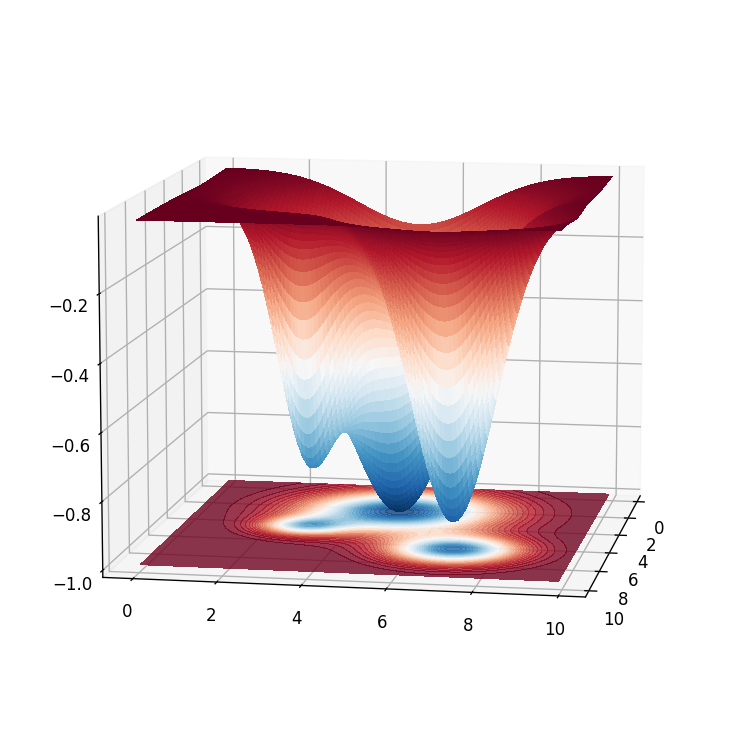

In [3]:
x = np.arange(x_limits[0],x_limits[1],0.1)
y = np.arange(y_limits[0],y_limits[1],0.1)
X,Y = np.meshgrid(x, y)
Z = function_2D(X, Y) # evaluation of the function on the grid

fig = plt.figure(figsize=(8,8), dpi=120)
ax = fig.gca(projection='3d')
ax.view_init(elev=10., azim=10)
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.RdBu_r, linewidth=0, antialiased=False)
cset = ax.contourf(X, Y, Z, zdir='z', offset=np.min(Z), cmap=cm.RdBu_r, alpha=0.8,levels=40)
    
plt.show()

### Nested sampling algorithm

In [4]:
def generate_random_point(x_limits,y_limits):

    x = np.random.uniform(x_limits[0],x_limits[1])
    y = np.random.uniform(y_limits[0],y_limits[1])

    f=function_2D(x,y)
    
    return ([x,y],f)

In [5]:
def create_walkers(n_walkers,x_limits,y_limits):
    """create the initial set of walkers = choose a number of uniformly random points in the range we want to study """
    walkers=[] # walkers' "coordinates"
    likelihood=[] # likelihood value of walkers
    
    for i in range(n_walkers):
        
        ([x,y],f) = generate_random_point(x_limits,y_limits)
        
        walkers.append([x,y])
        likelihood.append(f)
        #print(i,'-th walker created, with likelihood:', f)
        
    return (walkers,likelihood)

### Nested sampling parameters

In [6]:
n_walkers = 100      # number of walkers, i.e. size of the live set
ns_iterations = 1000 # number of NS iterations to reach convergence (=all walkers near the maximum likelihood)
                     # the more walkers, the more iterations will be needed
max_trial = 10000 # max random trials for generating new point - avoid getting into an infinite cycle

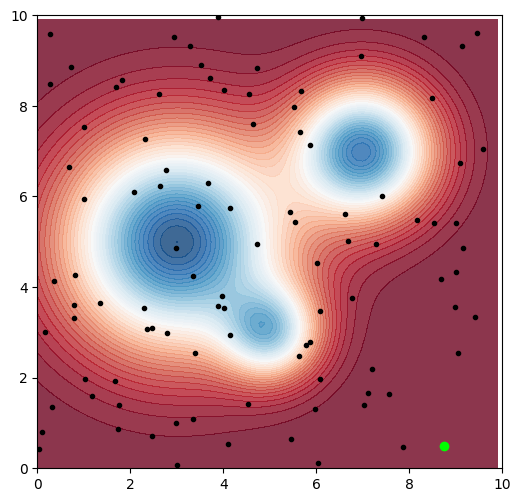

In [27]:
# Create all walkers and plot them.
(walkers,energy)=create_walkers(n_walkers=n_walkers,x_limits=x_limits,y_limits=y_limits)

index_max = np.argmax(energy)

fig = plt.figure(figsize=(6,6), dpi=100)
np_walkers=np.array(walkers)
plt.contourf(X,Y,Z,levels=40,cmap=cm.RdBu_r,alpha=0.8)
plt.plot(np_walkers[:,0],np_walkers[:,1],".",color='k')
plt.plot(np_walkers[index_max,0],np_walkers[index_max,1],"o",color='lime') # highest energy point among the initial walkers
plt.xlim(0,x_limits[1])
plt.ylim(0,y_limits[1])
plt.draw()

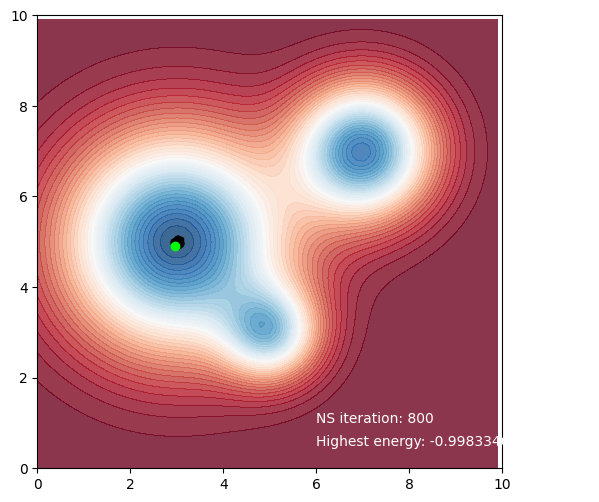

Could not find acceptable point within 10000 trials. STOP.
NS is done
Exact integral: -22.755 , NS_integral= -21.787018577226814 ( 95.7460715325283 % )


In [28]:
# Area and NS weight to be used for the integral
Area = (x_limits[1]-x_limits[0])*(y_limits[1]-y_limits[0])
alpha = n_walkers / (n_walkers+1) # nested sampling weight
Integral = 0.0 
#plot_walkers(walkers, energy)

fig = plt.figure(figsize=(6,6), dpi=100)
np_walkers=np.array(walkers)

# Start nested sampling iteration
for ns_iter in range(ns_iterations):

    index_max = np.argmax(energy) # find point with highest energy (lowest likelihood)
    E_limit = energy[index_max]   # this is the current highest-limit for energy
    Integral += (alpha**(ns_iter-1) - alpha**ns_iter) * E_limit * Area # update integral
    
    if (np.mod(ns_iter,10)==0):
        #print(ns_iter,E_limit,Integral) # keep track of how far we got
        plt.close()
        display.clear_output(wait=True)
        fig = plt.figure(figsize=(6,6), dpi=100)
        np_walkers=np.array(walkers)
        plt.contourf(X,Y,Z,levels=40,cmap=cm.RdBu_r,alpha=0.8)
        plt.plot(np_walkers[:,0],np_walkers[:,1],".",color='k')
        plt.plot(np_walkers[index_max,0],np_walkers[index_max,1],"o",color='lime') # highest energy point among the initial walkers
        plt.xlim(0,x_limits[1])
        plt.ylim(0,y_limits[1])
        plt.text(6,1,"NS iteration: "+str(ns_iter),color="white")
        plt.text(6,0.5,"Highest energy: "+str(E_limit),color="white")
        plt.draw()
        time.sleep(0.1)
        plt.pause(0.0001)         
               
            
    # generate new point which has higher likelihood than the current limit 
    i_trial=0
    E_new=E_limit+1.0
    while E_new > E_limit and i_trial < max_trial:
        # Here we generate a new point by drawing uniform x,y pairs in the entire range until we find one
        # which has a likelihood larger than the current limit. In more complex cases, in high-dimensional
        # functions, or where the basins/peaks narrow much more quickly, it becomes quickly unaffordable to choose 
        # successful candidate points randomly. The way we usually work around this, is to pick randomly 
        # one of the existing walkers, and perform a random walk(=random steps accepted if the likelihood 
        # stays larger than the limit) until we become "independent" of the starting point. This will be
        # our new walker.
        ([x,y],E_new) = generate_random_point(x_limits,y_limits)
        i_trial = i_trial+1
        
    if i_trial == max_trial :
        print('Could not find acceptable point within',max_trial,'trials. STOP.')
        break
    else:    
        # update 'worst' walker with the new point
        walkers[index_max]=[x,y]
        energy[index_max]=E_new

print("NS is done")
print('Exact integral:',Exact,', NS_integral=',Integral, '(', (Integral/Exact)*100, '% )')        